In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skl2onnx import to_onnx
from onnxruntime import InferenceSession
%matplotlib inline

In [3]:
# Load the data
data_path = "filled_data.csv"
data = pd.read_csv(data_path)

# Extract the relevant columns
datetime_column = pd.to_datetime(data['datetime'])
# Get all feature columns except 'datetime'
feature_columns = data.columns[1:]  # Exclude the 'datetime' column



In [4]:
def build_training_data(hourly_data_path):
    """Build training data from hourly data function. Skips NaN'd days."""

    hourly_data = pd.read_csv(hourly_data_path)
    
    print('Loaded hourly data')

    # integrated power consumption

    dec = [] # daily energy consumption
    t_dec = []

    time = pd.to_datetime(hourly_data['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S').values.astype('datetime64[s]')

    
    power_consumption = hourly_data['kw_total_zone2'].values

    for ti, t in enumerate(time):
        tmp_t = pd.Timestamp(t)

        if np.isclose(tmp_t.hour, 0) and np.isclose(tmp_t.minute, 0):

            day_end = np.datetime64(tmp_t + pd.Timedelta(days=1))
            ind = np.where((tmp_t < time) & (time < day_end), True, False)

            if len(time[ind]) > 0 and not np.isnan(power_consumption[ind]).any():
                t_dec.append(np.datetime64(tmp_t).astype('datetime64[s]'))
                dec.append(np.trapz(power_consumption[ind], time[ind].astype(int))/3600) # integrated kW to kJ then to kWh

    # time series of daily energy consumption
    t_dec = np.array(t_dec)
    dec = np.array(dec)

    print('Calculated daily energy consumption')

    # seperating predictors

    N = 7 # N days of predictors beforehand
    final_ind = []
    final_hourly = []

    predictor_window = pd.Timedelta(days=N)

    for ti, t in enumerate(t_dec):
        tmp_t = pd.Timestamp(t)
        ind = np.where((tmp_t - predictor_window <= time) & (time < tmp_t), True, False) # finding indices within the N prior days

        bad_ind = np.isnan(hourly_data.iloc[ind, 1::].values)
        if len(time[ind]) >= 24 * N and not bad_ind.any(): # rejecting any data with NaNs; useful for the student dataset
            final_ind.append(ti)
            final_hourly.append(hourly_data.iloc[ind, 1::].values) # dropping datetime column

    # getting targets and predictors
    target_time = t_dec[final_ind]
    targets = dec[final_ind]
    predictors = np.array(final_hourly)

    print('Calculated predictor window')

    return target_time, targets, predictors


In [5]:
data.shape

(17520, 28)

In [140]:
target_time, target, predictors = build_training_data('filled_data.csv')
print(target.shape)
print(predictors.shape)

Loaded hourly data
Calculated daily energy consumption
Calculated predictor window
(723,)
(723, 168, 27)


In [141]:
# Exclude the first column (datetime)
input_data = data.iloc[:, 1:]

# Calculate the number of days (excluding the first week)
num_days = 730 - 7  # 730 days with the first 7 days skipped

# Initialize the 3D array
targets = np.zeros((num_days, 24, input_data.shape[1]))

# Iterate through each day and extract the data
for day in range(num_days):
    start_index = day * 24 + 7 * 24
    end_index = start_index + 24
    targets[day, :, :] = input_data.iloc[start_index:end_index, :]

targets = targets[:, :, 22]




In [142]:
target.shape

(723,)

In [143]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the array to (723 * 168, 27) to apply MinMaxScaler
reshaped_predictors = predictors.reshape(-1, 27)

# Fit and transform the data
scaled_predictors = scaler.fit_transform(reshaped_predictors)

# Reshape the scaled data back to the original shape
predictors = scaled_predictors.reshape(predictors.shape)


reshaped_target = target.reshape(-1, 1)
targets = scaler.fit_transform(targets)
# target = scaler.fit_transform(reshaped_target)

print(predictors.shape)
print(targets.shape)


(723, 168, 27)
(723, 24)


In [145]:
target

array([ 45.964 ,  57.7505, 111.2795,  96.0515, 101.8965,  99.7285,
        94.511 ,  57.508 , 114.774 ,  93.792 ,  93.4475, 112.281 ,
       115.297 , 118.8145,  73.7635,  86.311 , 136.9215, 153.8915,
       133.4875, 135.096 , 117.304 ,  84.843 ,  83.3405, 131.4165,
       114.0025, 106.866 , 111.908 , 120.7865,  87.6235,  80.3305,
       128.498 , 112.137 , 103.4025, 112.5355,  42.042 ,  84.628 ,
        83.502 , 120.259 , 123.7475,  95.3705,  99.6945, 100.811 ,
        85.2775,  72.92  , 129.1965, 117.6265, 100.132 ,  46.6155,
         0.    ,   0.    ,   0.    ,   0.    ,  69.1785, 113.221 ,
       121.546 , 119.482 ,  96.725 , 100.513 , 133.441 , 137.3975,
       128.049 , 106.4715, 104.6025,  77.    ,  79.916 , 136.4105,
       113.67  , 115.5505, 117.4545, 108.7525,  77.9595,  88.5905,
        90.288 ,  94.1555,  93.595 ,  95.823 ,  80.916 ,  69.3975,
        72.165 , 102.893 , 100.64  ,  99.65  , 146.777 , 168.554 ,
        94.037 ,  96.7305, 134.1015, 104.7505, 115.0815,  76.5

In [146]:
from sklearn.model_selection import train_test_split

# split_index = int(len(targets) * 0.8)

# # Split the vectors into training and testing sets
# train_y, test_y = target[:split_index], target[split_index:]
# train_X, test_X = predictors[:split_index], predictors[split_index:]

train_X, test_X, train_y, test_y = train_test_split(predictors, targets, test_size=0.2, random_state=42)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(578, 168, 27) (578, 24) (145, 168, 27) (145, 24)


In [98]:
# import tensorflow as tf

# def relative_squared_error(y_true, y_pred):
#     """Relative squared error."""
#     y_true_np = tf.keras.backend.eval(y_true)
#     y_pred_np = tf.keras.backend.eval(y_pred)

#     return np.mean((y_pred_np - y_true_np)**2) / np.mean((y_true_np - np.mean(y_true_np))**2)

In [132]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchmetrics.regression import RelativeSquaredError

In [133]:
# relative_squared_error = RelativeSquaredError()

In [162]:
# # Define the PyTorch model
# class MyModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MyModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # Take the output from the last time step
#         return out

In [135]:
# # Convert data to PyTorch tensors
# train_X_torch, train_y_torch = torch.Tensor(train_X), torch.Tensor(train_y)
# test_X_torch, test_y_torch = torch.Tensor(test_X), torch.Tensor(test_y)

In [140]:
# # Initialize model, loss function, and optimizer
# input_size = train_X_torch.shape[2]
# hidden_size = 7
# output_size = 1
# model = MyModel(input_size, hidden_size, output_size)
# criterion = relative_squared_error  
# optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [137]:
# from torch.utils.data import TensorDataset, DataLoader

# # Create DataLoader for training and testing
# train_dataset = TensorDataset(train_X_torch, train_y_torch)
# train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)

# test_dataset = TensorDataset(test_X_torch, test_y_torch)
# test_loader = DataLoader(test_dataset, batch_size=36, shuffle=False)

In [163]:
# # Training loop
# num_epochs = 50
# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1))
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             outputs = model(inputs)
#             val_loss = criterion(outputs, targets.unsqueeze(1))

#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

In [117]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return K.mean((y_pred - y_true)**2)/K.mean((y_true - K.mean(y_true))**2)

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [148]:
[x.shape for x in [train_X, train_y, test_X, test_y]]

[(578, 168, 27), (578, 24), (145, 168, 27), (145, 24)]

In [149]:


# Design Lambda
int_layer = Lambda(lambda x: K.sum(x, axis=1))

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(24))
# model.add(Dense(1))
# model.add(int_layer)
model.compile(loss='mse', optimizer='adam')
# fit network


history = model.fit(train_X, train_y, epochs=100, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
17/17 - 5s - loss: 0.0532 - val_loss: 0.0311 - 5s/epoch - 292ms/step
Epoch 2/100
17/17 - 2s - loss: 0.0224 - val_loss: 0.0216 - 2s/epoch - 119ms/step
Epoch 3/100
17/17 - 1s - loss: 0.0177 - val_loss: 0.0184 - 1s/epoch - 68ms/step
Epoch 4/100
17/17 - 2s - loss: 0.0159 - val_loss: 0.0176 - 2s/epoch - 99ms/step
Epoch 5/100
17/17 - 1s - loss: 0.0152 - val_loss: 0.0177 - 1s/epoch - 74ms/step
Epoch 6/100
17/17 - 2s - loss: 0.0147 - val_loss: 0.0182 - 2s/epoch - 113ms/step
Epoch 7/100
17/17 - 2s - loss: 0.0144 - val_loss: 0.0183 - 2s/epoch - 97ms/step
Epoch 8/100
17/17 - 2s - loss: 0.0142 - val_loss: 0.0182 - 2s/epoch - 94ms/step
Epoch 9/100
17/17 - 2s - loss: 0.0141 - val_loss: 0.0177 - 2s/epoch - 92ms/step
Epoch 10/100
17/17 - 2s - loss: 0.0139 - val_loss: 0.0168 - 2s/epoch - 89ms/step
Epoch 11/100
17/17 - 1s - loss: 0.0136 - val_loss: 0.0163 - 1s/epoch - 86ms/step
Epoch 12/100
17/17 - 1s - loss: 0.0133 - val_loss: 0.0163 - 1s/epoch - 76ms/step
Epoch 13/100
17/17 - 1s - loss: 0.

In [150]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 100)               51200     
                                                                 
 dense_17 (Dense)            (None, 24)                2424      
                                                                 
Total params: 53624 (209.47 KB)
Trainable params: 53624 (209.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


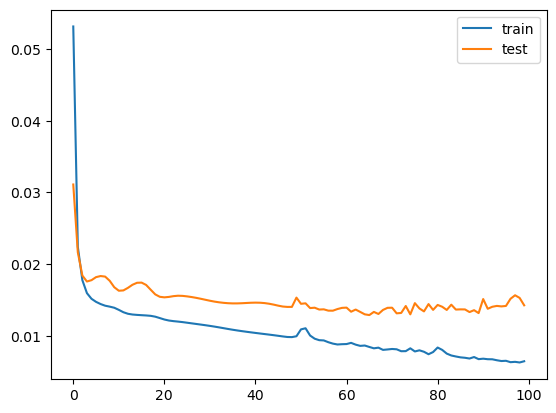

In [151]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [152]:
# make a prediction
yhat = model.predict(predictors)
yhat.shape

23/23 [==============================] - 1s 20ms/step


(723, 24)

In [154]:
target

array([ 45.964 ,  57.7505, 111.2795,  96.0515, 101.8965,  99.7285,
        94.511 ,  57.508 , 114.774 ,  93.792 ,  93.4475, 112.281 ,
       115.297 , 118.8145,  73.7635,  86.311 , 136.9215, 153.8915,
       133.4875, 135.096 , 117.304 ,  84.843 ,  83.3405, 131.4165,
       114.0025, 106.866 , 111.908 , 120.7865,  87.6235,  80.3305,
       128.498 , 112.137 , 103.4025, 112.5355,  42.042 ,  84.628 ,
        83.502 , 120.259 , 123.7475,  95.3705,  99.6945, 100.811 ,
        85.2775,  72.92  , 129.1965, 117.6265, 100.132 ,  46.6155,
         0.    ,   0.    ,   0.    ,   0.    ,  69.1785, 113.221 ,
       121.546 , 119.482 ,  96.725 , 100.513 , 133.441 , 137.3975,
       128.049 , 106.4715, 104.6025,  77.    ,  79.916 , 136.4105,
       113.67  , 115.5505, 117.4545, 108.7525,  77.9595,  88.5905,
        90.288 ,  94.1555,  93.595 ,  95.823 ,  80.916 ,  69.3975,
        72.165 , 102.893 , 100.64  ,  99.65  , 146.777 , 168.554 ,
        94.037 ,  96.7305, 134.1015, 104.7505, 115.0815,  76.5

In [155]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat

array([[1.5695202, 1.4653051, 1.4801477, ..., 1.6364708, 1.5835037,
        1.8261514],
       [2.5687675, 2.8156798, 2.3266876, ..., 2.8357508, 3.7612417,
        2.5879674],
       [3.3522751, 3.1384945, 2.3684847, ..., 2.3840845, 2.520568 ,
        2.585825 ],
       ...,
       [2.3745978, 2.8416493, 2.68911  , ..., 2.2530613, 1.8284925,
        2.2340782],
       [2.0222251, 2.6279488, 2.445529 , ..., 2.3010185, 1.8934578,
        2.282186 ],
       [2.118989 , 2.5592656, 2.3824704, ..., 2.428245 , 2.3225873,
        2.357263 ]], dtype=float32)

In [156]:
predicted_kw_zone2 = np.trapz(inv_yhat, axis=1)
predicted_kw_zone2

array([ 55.022697 ,  70.919464 , 100.55636  ,  95.20558  , 103.3436   ,
        97.5114   , 103.83366  ,  62.861786 , 120.41431  , 106.729164 ,
        90.11787  ,  91.37427  , 137.85979  ,  97.68127  ,  92.25388  ,
        92.86104  , 138.23138  , 165.79623  , 146.49074  , 134.60782  ,
       107.53479  ,  86.60842  ,  87.76163  , 126.75013  , 127.26674  ,
        96.11393  , 102.402245 , 123.77095  ,  86.627625 ,  84.36814  ,
       107.62329  , 132.92508  ,  92.97724  , 118.089424 ,  41.436848 ,
        92.87679  ,  78.06873  , 131.09607  , 135.90187  , 113.83728  ,
       103.01311  ,  98.55249  ,  98.69027  ,  80.620155 , 114.18358  ,
       124.39566  , 100.22065  ,  58.027184 ,   5.0017033,  24.095974 ,
         4.7767353,   2.5125406,  68.93039  , 114.303986 , 113.211655 ,
       130.42686  ,  94.85252  , 108.24083  , 140.2749   , 147.61687  ,
       111.31871  , 120.428246 ,  98.31451  ,  98.704315 ,  86.194916 ,
       129.01054  , 117.43226  , 122.23295  , 123.15743  , 107.5

In [157]:
for i in range (len(predicted_kw_zone2)):
  print(predicted_kw_zone2[i], target[i])

55.022697 45.964000000000006
70.919464 57.75049999999999
100.55636 111.27949999999998
95.20558 96.05150000000002
103.3436 101.8965
97.5114 99.7285
103.83366 94.511
62.861786 57.508
120.41431 114.774
106.729164 93.792
90.11787 93.44750000000002
91.37427 112.281
137.85979 115.29699999999998
97.68127 118.81450000000002
92.25388 73.7635
92.86104 86.311
138.23138 136.92149999999998
165.79623 153.89149999999998
146.49074 133.4875
134.60782 135.09600000000003
107.53479 117.304
86.60842 84.843
87.76163 83.34049999999999
126.75013 131.41649999999998
127.26674 114.0025
96.11393 106.86600000000001
102.402245 111.908
123.77095 120.7865
86.627625 87.6235
84.36814 80.33050000000001
107.62329 128.498
132.92508 112.13699999999999
92.97724 103.40249999999999
118.089424 112.53550000000001
41.436848 42.04200000000001
92.87679 84.628
78.06873 83.50200000000001
131.09607 120.25899999999999
135.90187 123.74749999999999
113.83728 95.37050000000004
103.01311 99.69449999999999
98.55249 100.811
98.69027 85.2775

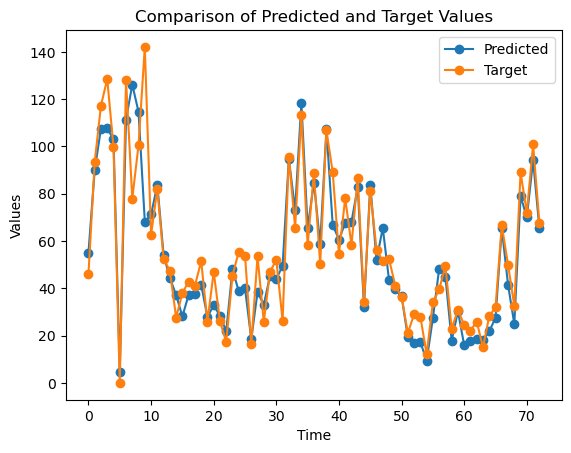

In [161]:
# Plotting
plt.plot(predicted_kw_zone2[::10], 'o-', label='Predicted')
plt.plot(target[::10], 'o-', label='Target')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison of Predicted and Target Values')
plt.legend()
plt.show()

In [162]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return np.mean((y_pred - y_true)**2)/np.mean((y_true - y_true.mean())**2)

print(relative_squared_error(predicted_kw_zone2, target))

0.10986166914463355
